In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue

from tbu_gym.tbu_discrete import TruckBackerEnv_D


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# DQN Agent

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-5, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        # device, not needed, but needed if going on canada compute to specify gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.q_nn = self.build_nn().to(self.device) # build q network
        self.target_net = self.build_nn().to(self.device) # build target network
        self.target_net.load_state_dict(self.q_nn.state_dict()) # make target net same as q net. initialization is random so need this
        self.optimizer = optim.Adam(self.q_nn.parameters(), lr=lr) 
        
    def build_nn(self): # to build the q network, 2 hiddne layer with relu and 128 neuronsin each
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )
    
    def agent_policy(self, state): # act e greedy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim) # rand action
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device) # convert state to tensor, then add batch dimension, then move to device
        with torch.no_grad(): # dont calculate gradients, no need
            q_values = self.q_nn(state)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # store transition sars, done is if terminal state
    
    def train_with_mem(self): # train with experience from memory using batch size set in agent
        if len(self.memory) < self.batch_size: # if not enought mem, could be changed to use what we have instead of skip
            return
        batch = random.sample(self.memory, self.batch_size) # get batch
        states, actions, rewards, next_states, dones = zip(*batch) # get batch features

        # convert data to tensors which can be used by pytorch
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device) 
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # get current q values from q network
        q_values = self.q_nn(states).gather(1, actions)

        # use the samples from experience batch to calc target network q values
        with torch.no_grad(): # no need to calc gradients for target
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]  
        # target = r + gamma * max_a' Q(s', a') * (1 - done)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        # mean squared error 
        errors = target - q_values
        squared_errors = errors ** 2
        mean_squared_error = torch.mean(squared_errors)

        self.optimizer.zero_grad()
        mean_squared_error.backward()
        self.optimizer.step()
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

    
    def update_target(self): # update target network replacing it with the current q network
        self.target_net.load_state_dict(self.q_nn.state_dict())

# QRC Agent

In [3]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class QRCAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,
        gamma=0.99,
        lam=0.9,                # kept for API compatibility (not used here)
        epsilon=1.0,
        epsilon_decay=0.995,
        min_epsilon=0.01,
        buffer_size=50000,
        batch_size=64,
        beta=1.0,               # regularization strength for h (matches JAX self.beta)
        device=None,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.beta = beta

        # Replay memory
        self.memory = deque(maxlen=buffer_size)

        # Device
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

        # Networks
        self.q_net = self.build_nn(output_dim=self.action_dim).to(self.device)
        self.target_net = self.build_nn(output_dim=self.action_dim).to(self.device)
        self.h_net = self.build_nn(output_dim=self.action_dim).to(self.device)

        # init target
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizers
        self.q_optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.h_optimizer = optim.Adam(self.h_net.parameters(), lr=self.lr)

        # Steps counter
        self.steps = 0

    def build_nn(self, output_dim):
        """2 hidden layers with 128 neurons each"""
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def agent_policy(self, state):
        """Epsilon-greedy policy returning an int action"""
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(self.action_dim))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return int(q_values.argmax(dim=1).item())

    def remember(self, state, action, reward, next_state, done):
        """Store transition tuple"""
        self.memory.append((state, action, reward, next_state, done))

    def train_with_mem(self):
        """Train using experience replay. Returns total loss (q_loss + h_loss) for logging."""
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device)         # (B, state_dim)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)     # (B,1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)  # (B,1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)      # (B,1)

        # Current Q for taken actions (B,1)
        q_all = self.q_net(states)                                  # (B, A)
        q_values = q_all.gather(1, actions)                         # (B,1)

        # h-values for taken actions (B,1)
        h_all = self.h_net(states)
        h_values = h_all.gather(1, actions)                         # (B,1)

        # Next-state greedy value (use target_net), detach it
        with torch.no_grad():
            next_q_all = self.target_net(next_states)               # (B,A)
            # greedy next action value: max_a Q'(s', a)
            vtp1 = next_q_all.max(dim=1, keepdim=True)[0]          # (B,1)
            vtp1 = vtp1.detach()

            # Q target (standard Q-learning greedy target)
            target = rewards + self.gamma * vtp1 * (1.0 - dones)   # (B,1)
            target = target.detach()

        # TD error (not detached yet)
        delta = target - q_values                                   # (B,1)

        # Build v_loss and h_loss per-sample exactly like JAX:
        # v_loss_i = 0.5 * delta^2 + gamma * stop_gradient(delta_hat) * vtp1
        # h_loss_i = 0.5 * (stop_gradient(delta) - delta_hat)^2
        v_loss_terms = 0.5 * (delta ** 2) + self.gamma * h_values.detach() * vtp1
        h_loss_terms = 0.5 * (delta.detach() - h_values) ** 2

        v_loss = v_loss_terms.mean()
        h_loss = h_loss_terms.mean()

        # --- Update Q-network (q_net) ---
        self.q_optimizer.zero_grad()
        v_loss.backward(retain_graph=True)   # retain_graph because h_loss backward next might need graph if shared (here nets separate so optional)
        self.q_optimizer.step()

        # --- Update h-network (h_net) ---
        self.h_optimizer.zero_grad()
        h_loss.backward()
        self.h_optimizer.step()

        # --- Apply explicit decay / regularization on h parameters (beta term) ---
        # This approximates: params_h <- params_h - stepsize * beta * params_h
        # i.e. multiplicative shrinkage: p *= (1 - lr * beta)
        if self.beta != 0.0:
            decay_factor = 1.0 - (self.lr * self.beta)
            # clamp decay_factor to a sensible positive number
            decay_factor = max(decay_factor, 0.0)
            with torch.no_grad():
                for p in self.h_net.parameters():
                    p.mul_(decay_factor)

        # Decay epsilon
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.min_epsilon:
                self.epsilon = self.min_epsilon

        total_loss = v_loss.item() + h_loss.item()
        return total_loss

    def update_target(self):
        """Hard update target network weights from q_net"""
        self.target_net.load_state_dict(self.q_net.state_dict())

# Common Hyperparameters

In [4]:
num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 10

num_runs = 20  # number of independent simulations


# env = TruckBackerEnv_D(render_mode=None)
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.n

# DQN Testing

In [5]:
#hyper params, these are set by default in the agent but can be changed here
# num_episodes = 1000
# max_steps_per_episode = 500
# gamma = 0.99
# learning_rate = 1e-3
# epsilon_start = 1.0
# epsilon_decay = 0.99997
# epsilon_min = 0.01
# batch_size = 64
# target_update_freq = 5

#agent env setup
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    batch_size=batch_size
)

#training
episode_rewards_dqn = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps_per_episode):
  
        action = agent.agent_policy(state) # e greedy action
  
        # step env
        next_state, reward, done, info = env.step(action) # do a observe s',r and if terminal
        total_reward += reward

        #store transition in memory
        agent.remember(state, action, reward, next_state, done) # set s' = s a r and if terminal

        # train agent with memory, will train with batch size set in agent
        agent.train_with_mem() 

        state = next_state #s = s'

        if done: # if terminal state
            break


    if episode % target_update_freq == 0:
        agent.update_target()

    episode_rewards_dqn.append(total_reward)
    
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

Episode 1, Reward: -300, Epsilon: 0.993
Episode 2, Reward: -300, Epsilon: 0.984
Episode 3, Reward: -300, Epsilon: 0.975
Episode 4, Reward: -300, Epsilon: 0.966
Episode 5, Reward: -300, Epsilon: 0.958
Episode 6, Reward: -300, Epsilon: 0.949
Episode 7, Reward: -300, Epsilon: 0.941
Episode 8, Reward: -300, Epsilon: 0.932
Episode 9, Reward: -300, Epsilon: 0.924
Episode 10, Reward: -300, Epsilon: 0.916
Episode 11, Reward: -300, Epsilon: 0.907
Episode 12, Reward: -300, Epsilon: 0.899
Episode 13, Reward: -300, Epsilon: 0.891
Episode 14, Reward: -300, Epsilon: 0.883
Episode 15, Reward: -300, Epsilon: 0.875
Episode 16, Reward: -300, Epsilon: 0.868
Episode 17, Reward: -300, Epsilon: 0.860
Episode 18, Reward: -300, Epsilon: 0.852
Episode 19, Reward: -300, Epsilon: 0.844
Episode 20, Reward: -300, Epsilon: 0.837
Episode 21, Reward: -300, Epsilon: 0.829
Episode 22, Reward: -300, Epsilon: 0.822
Episode 23, Reward: -300, Epsilon: 0.815
Episode 24, Reward: -300, Epsilon: 0.807
Episode 25, Reward: -300,

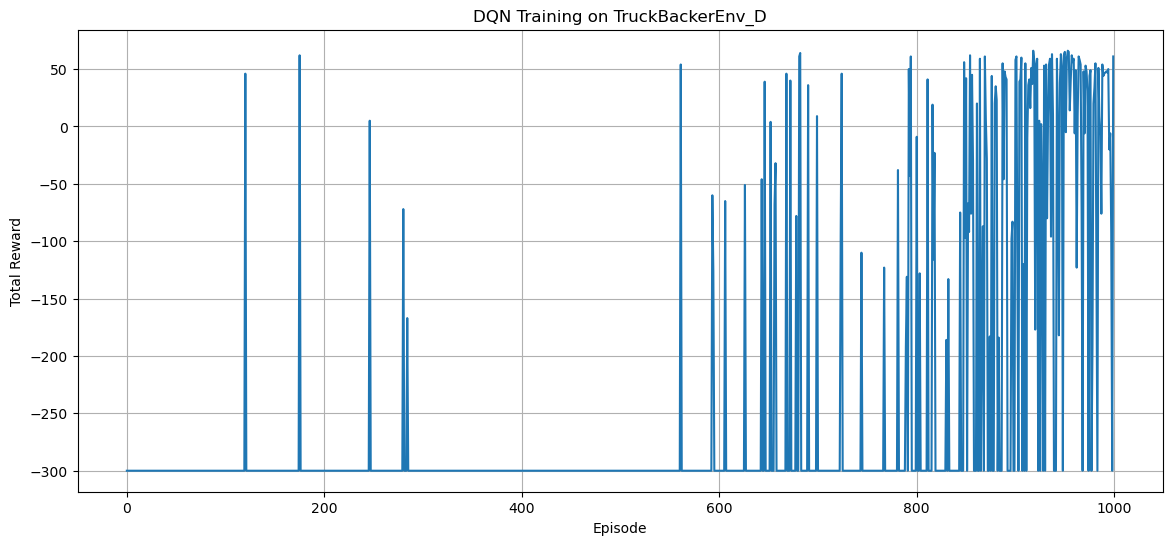

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(episode_rewards_dqn)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training on TruckBackerEnv_D')
plt.grid(True)

plt.show()

# QRC Testing

In [7]:
# --- 3. Training Script Setup and Execution ---

# Hyperparameters (user-defined and QRC-specific)
# num_episodes = 1000
# max_steps_per_episode = 500
# gamma = 0.99
# learning_rate = 1e-3
# epsilon_start = 1.0
# epsilon_decay = 0.99997
# epsilon_min = 0.01
# batch_size = 64
# target_update_freq = 5 # Target network update frequency in episodes

# QRC Specific Parameters (Defaults)
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0


# Environment Setup
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Agent Initialization (using QRCAgent)
# agent = QRCAgent(
#     state_dim=state_dim,
#     action_dim=action_dim,
#     lr=learning_rate,
#     gamma=gamma,
#     epsilon=epsilon_start,
#     epsilon_decay=epsilon_decay,
#     epsilon_min=epsilon_min,
#     batch_size=batch_size,
#     target_update_freq=target_update_freq,
#     alpha=alpha,
#     sigma_min=sigma_min,
#     sigma_max=sigma_max
# )
agent = QRCAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    min_epsilon=epsilon_min,
    batch_size=batch_size
)


# Training Loop
episode_rewards_qrc = []
recent_loss = 0.0 # Variable to track latest loss for printing

for episode in range(1, num_episodes + 1):
    # env.reset returns a tuple in modern gyms, ensure it's unpacked correctly
    state, info = env.reset() if isinstance(env.reset(), tuple) else (env.reset(), {})
    total_reward = 0

    for t in range(max_steps_per_episode):
        
        action = agent.agent_policy(state)
        
        # Check if environment step returns a tuple of (next_state, reward, terminated, truncated, info) or (next_state, reward, done, info)
        step_result = env.step(action)
        
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else: # assuming old gym signature (next_state, reward, done, info)
            next_state, reward, done, info = step_result

        total_reward += reward

        # Store transition in memory
        agent.remember(state, action, reward, next_state, done)

        # Train agent with memory
        current_loss = agent.train_with_mem()
        if current_loss != 0.0:
            recent_loss = current_loss

        state = next_state

        if done:
            break

    # Target Network Update (based on episode count)
    if episode % target_update_freq == 0:
        agent.update_target()

    episode_rewards_qrc.append(total_reward)
    
    # Print episode summary
    print(f"Episode {episode}/{num_episodes}, Reward: {total_reward:6.2f}, Epsilon: {agent.epsilon:.5f}, Loss: {recent_loss:.5f}")




Episode 1/1000, Reward: -300.00, Epsilon: 0.99292, Loss: 0.00179
Episode 2/1000, Reward: -300.00, Epsilon: 0.98402, Loss: 0.00323
Episode 3/1000, Reward: -300.00, Epsilon: 0.97520, Loss: 0.00473
Episode 4/1000, Reward: -300.00, Epsilon: 0.96646, Loss: 0.00349
Episode 5/1000, Reward: -300.00, Epsilon: 0.95781, Loss: 0.00158
Episode 6/1000, Reward: -300.00, Epsilon: 0.94922, Loss: 0.00077
Episode 7/1000, Reward: -300.00, Epsilon: 0.94072, Loss: 0.00114
Episode 8/1000, Reward: -300.00, Epsilon: 0.93229, Loss: 0.00150
Episode 9/1000, Reward: -116.00, Epsilon: 0.92624, Loss: 0.00171
Episode 10/1000, Reward: -300.00, Epsilon: 0.91794, Loss: 0.00369
Episode 11/1000, Reward: -300.00, Epsilon: 0.90972, Loss: 0.02058
Episode 12/1000, Reward: -300.00, Epsilon: 0.90157, Loss: 0.01331
Episode 13/1000, Reward: -300.00, Epsilon: 0.89349, Loss: 0.01163
Episode 14/1000, Reward: -300.00, Epsilon: 0.88548, Loss: 0.05786
Episode 15/1000, Reward: -300.00, Epsilon: 0.87755, Loss: 0.00599
Episode 16/1000, Re

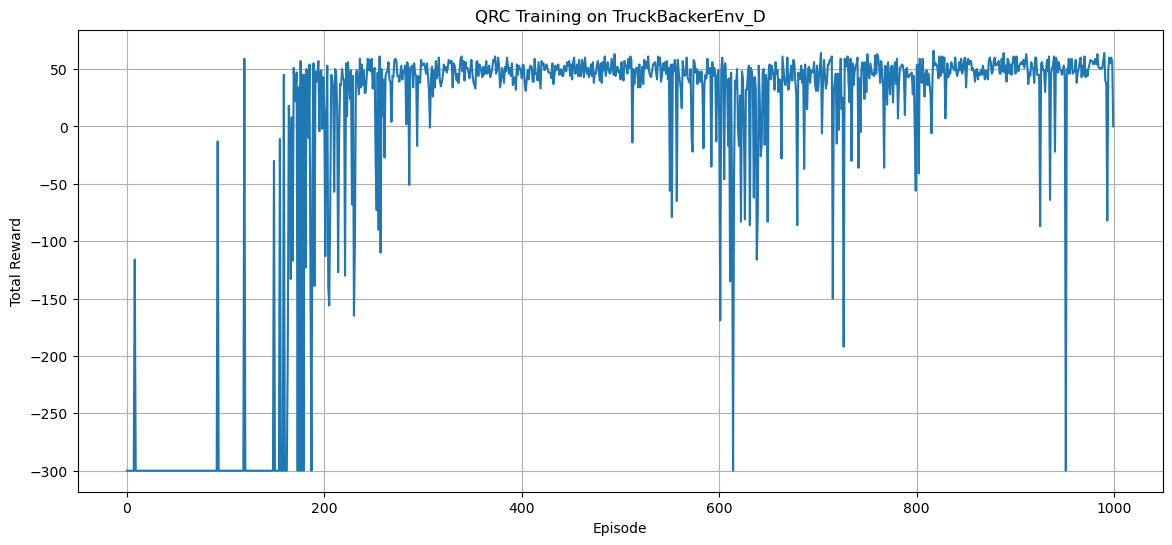

In [8]:
# Plotting Results
plt.figure(figsize=(14, 6))
plt.plot(episode_rewards_qrc)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)
plt.show()

# Compare QRC and DQN

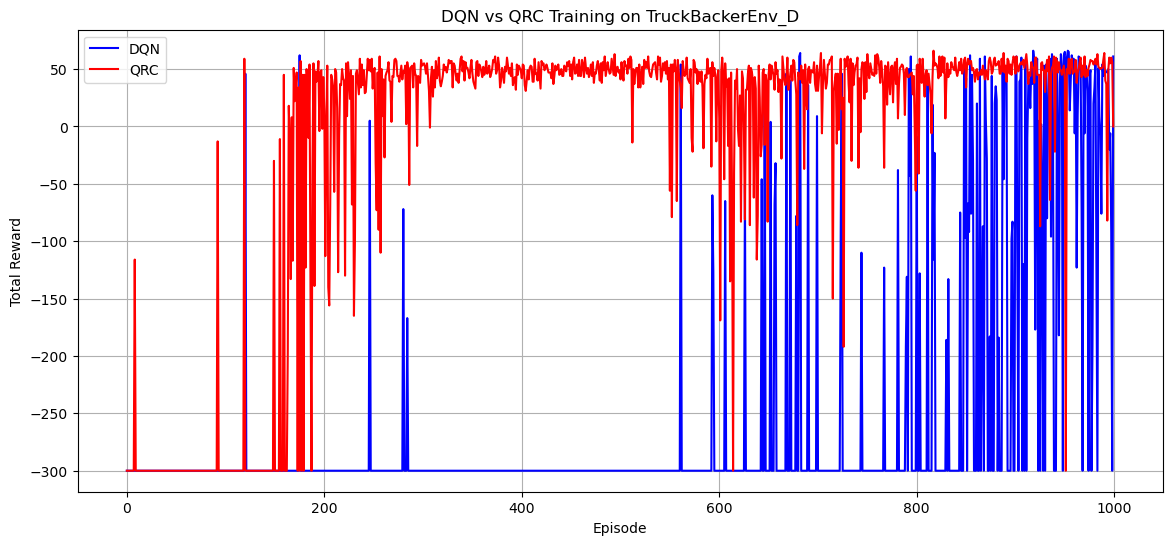

In [9]:
# Side-by-side plot of DQN vs QRC rewards
plt.figure(figsize=(14, 6))

# DQN rewards (assuming stored in `dqn_rewards` list)
plt.plot(episode_rewards_dqn, label='DQN', color='blue')

# QRC rewards (assuming stored in `episode_rewards_qrc` list)
plt.plot(episode_rewards_qrc, label='QRC', color='red')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN vs QRC Training on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.show()

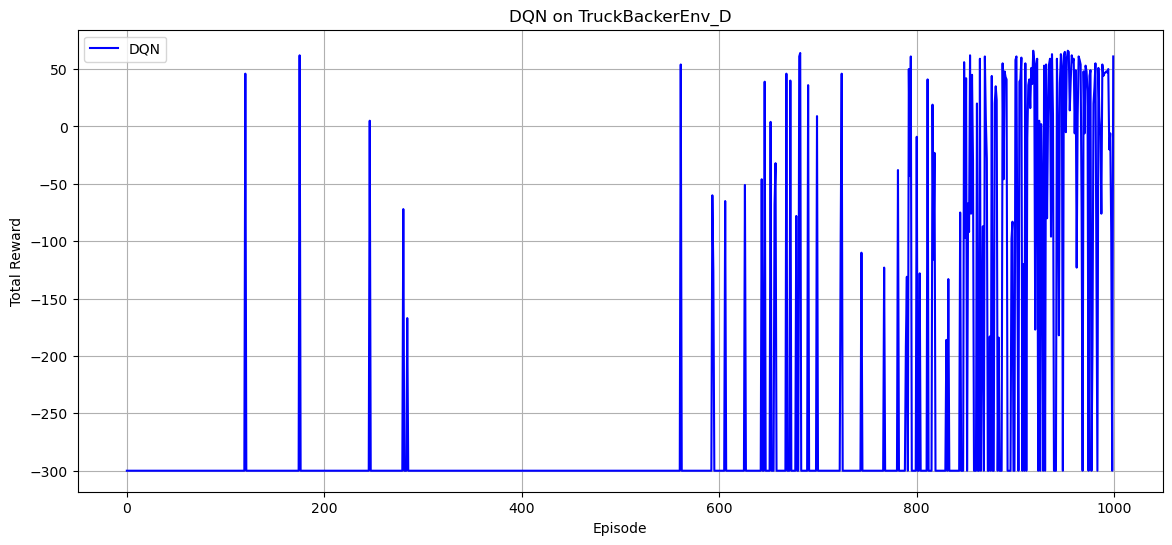

In [10]:
# Side-by-side plot of DQN vs QRC rewards
plt.figure(figsize=(14, 6))

# DQN rewards (assuming stored in `dqn_rewards` list)
plt.plot(episode_rewards_dqn, label='DQN', color='blue')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.show()

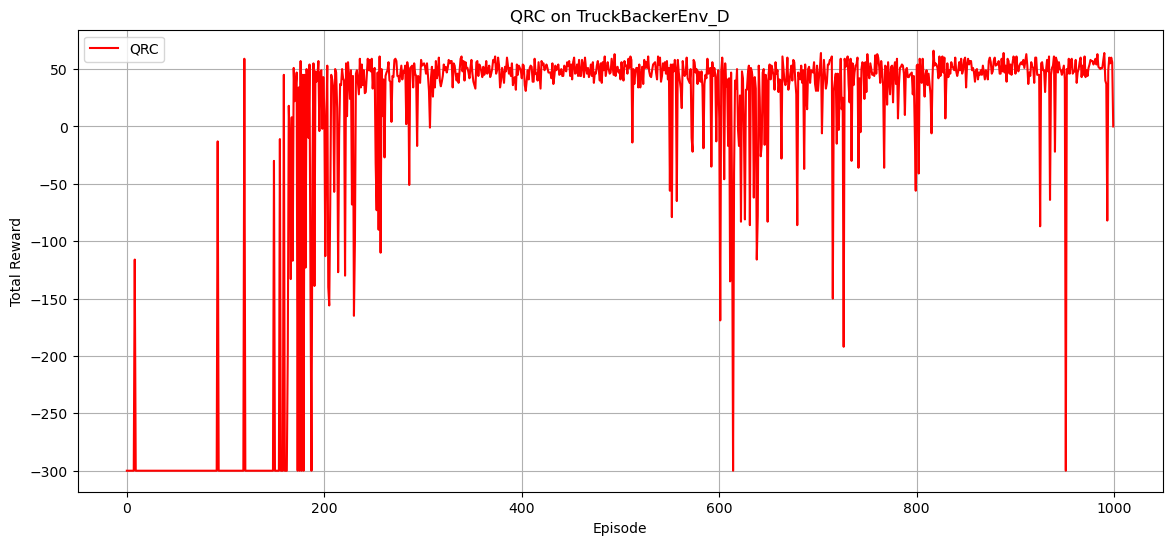

In [11]:
# Side-by-side plot of DQN vs QRC rewards
plt.figure(figsize=(14, 6))

# QRC rewards (assuming stored in `dqn_rewards` list)
plt.plot(episode_rewards_qrc, label='QRC', color='red')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.show()

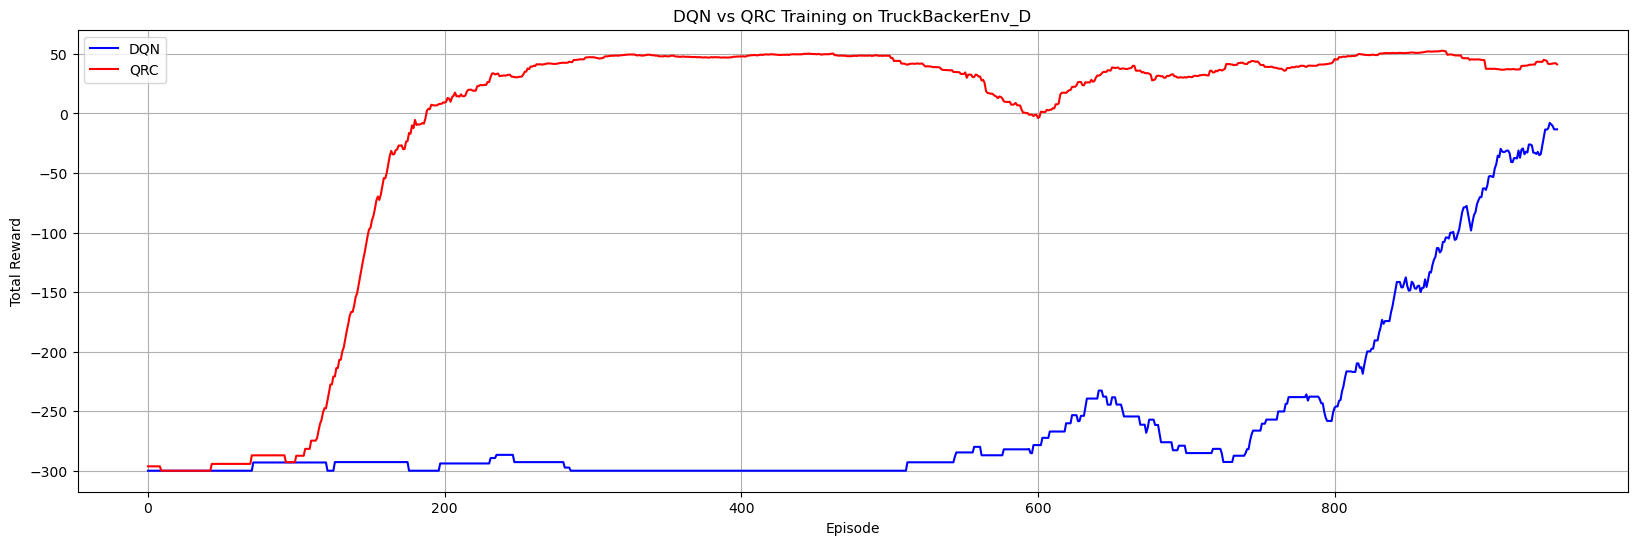

In [12]:
window = 50
smoothed_dqn = np.convolve(episode_rewards_dqn, np.ones(window)/window, mode='valid')
smoothed_qrc = np.convolve(episode_rewards_qrc, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(smoothed_dqn, label='DQN', color='blue')
plt.plot(smoothed_qrc, label='QRC', color='red')


plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN vs QRC Training on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.show()

Run 1/20 finished.
Run 2/20 finished.
Run 3/20 finished.
Run 4/20 finished.
Run 5/20 finished.
Run 6/20 finished.
Run 7/20 finished.
Run 8/20 finished.
Run 9/20 finished.
Run 10/20 finished.
Run 11/20 finished.
Run 12/20 finished.
Run 13/20 finished.
Run 14/20 finished.
Run 15/20 finished.
Run 16/20 finished.
Run 17/20 finished.
Run 18/20 finished.
Run 19/20 finished.
Run 20/20 finished.


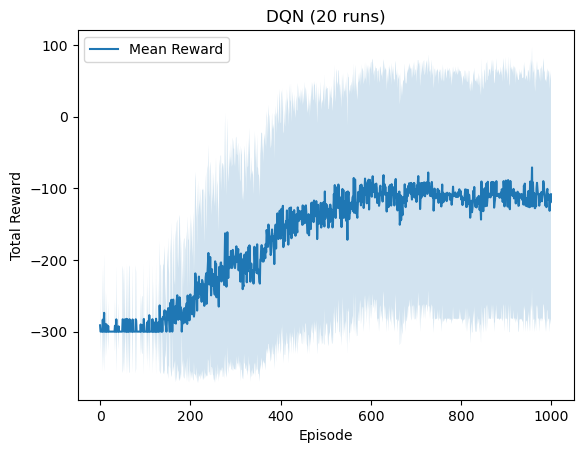

In [13]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

all_rewards = []

for run in range(num_runs):
    # set random seeds for reproducibility
    seed = run
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # reinitialize environment and agent each run
    env = TruckBackerEnv_D(render_mode=None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=learning_rate,
        gamma=gamma,
        epsilon=epsilon_start,
        epsilon_decay=epsilon_decay,
        epsilon_min=epsilon_min,
        batch_size=batch_size
    )

    episode_rewards = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps_per_episode):
            action = agent.agent_policy(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            agent.train_with_mem()
            state = next_state
            if done:
                break

        if episode % target_update_freq == 0:
            agent.update_target()

        episode_rewards.append(total_reward)

    all_rewards.append(episode_rewards)
    print(f"Run {run+1}/{num_runs} finished.")

# --- Compute mean and std over runs ---
mean_rewards_dqp = np.mean(all_rewards, axis=0)
std_rewards_dqp = np.std(all_rewards, axis=0)

# --- Plot learning curve with error bands ---
plt.plot(mean_rewards_dqp, label="Mean Reward")
plt.fill_between(range(num_episodes),
                 mean_rewards_dqp - std_rewards_dqp,
                 mean_rewards_dqp + std_rewards_dqp,
                 alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title(f"DQN ({num_runs} runs)")
plt.show()

In [ ]:
# QRC-specific parameters
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0

# ========================================
# --- 2. Multi-Run Setup ---
# ========================================
all_rewards_qrc = []

for run in range(num_runs):
    print(f"\n=== Starting Run {run + 1}/{num_runs} ===")

    # --- Random Seed for Reproducibility ---
    seed = run
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # --- Environment Setup ---
    env = TruckBackerEnv_D(render_mode=None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # --- Agent Initialization ---
    agent = QRCAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=learning_rate,
        gamma=gamma,
        epsilon=epsilon_start,
        epsilon_decay=epsilon_decay,
        min_epsilon=epsilon_min,
        batch_size=batch_size
    )

    episode_rewards = []
    recent_loss = 0.0

    # ========================================
    # --- 3. Training Loop ---
    # ========================================
    for episode in range(1, num_episodes + 1):
        # handle Gym reset signature
        reset_output = env.reset()
        state, info = reset_output if isinstance(reset_output, tuple) else (reset_output, {})
        total_reward = 0

        for t in range(max_steps_per_episode):
            action = agent.agent_policy(state)

            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result

            total_reward += reward

            # memory + training
            agent.remember(state, action, reward, next_state, done)
            current_loss = agent.train_with_mem()
            if current_loss != 0.0:
                recent_loss = current_loss

            state = next_state
            if done:
                break

        # target update
        if episode % target_update_freq == 0:
            agent.update_target()

        episode_rewards.append(total_reward)

        # print(f"[Run {run+1}] Ep {episode}/{num_episodes} | "
        #       f"Reward: {total_reward:6.2f} | Eps: {agent.epsilon:.5f} | Loss: {recent_loss:.5f}")

    all_rewards_qrc.append(episode_rewards)
    print(f"=== Run {run + 1} complete! ===")

# ========================================
# --- 4. Aggregate Results ---
# ========================================
mean_rewards_qrc = np.mean(all_rewards_qrc, axis=0)
std_rewards_qrc = np.std(all_rewards_qrc, axis=0)

# ========================================
# --- 5. Plotting ---
# ========================================
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards_qrc, label="QRC Mean Reward")
plt.fill_between(
    range(num_episodes),
    mean_rewards_qrc - std_rewards_qrc,
    mean_rewards_qrc + std_rewards_qrc,
    alpha=0.2
)
plt.title(f"QRC Training Performance ({num_runs} runs)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

# ========================================
# --- 6. Optional: Save Results ---
# ========================================
np.save("qrc_all_rewards.npy", all_rewards_qrc)
print("Saved rewards to qrc_all_rewards.npy")


=== Starting Run 1/20 ===


In [ ]:
window = 50
smoothed_dqn = np.convolve(mean_rewards_dqp, np.ones(window)/window, mode='valid')
smoothed_qrc = np.convolve(mean_rewards_qrc, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(smoothed_dqn, label='DQN', color='blue')
plt.plot(smoothed_qrc, label='QRC', color='red')


plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN vs QRC Training on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.show()